### Mask R-CNN
1. Mask R-CNN은 image segmentation을 위해서 고안된 모델이다.
2. 기본적으로 사용하기에 매우 쉽고(훈련된 모델에 backbone모델만 사용자가 적절하게 넣어주면 된다.)  
  1. 기존에 사용이 되던 Fast/Faster R-CNN, 그리고 Fully Convolutional Network의 성능을 Coco 2016 datatset을 이용한 대회 등에서의 성능으로부터 모두 우수
3. object detection, semantic segmentation 뿐만 아니라 instance segmentation에서 우수

### Mask R-CNN의 구조 / 실행 과정## Mask R-CNN
1. Mask R-CNN은 image segmentation을 위해서 고안된 모델이다.
2. 기본적으로 사용하기에 매우 쉽고(훈련된 모델에 backbone모델만 사용자가 적절하게 넣어주면 된다.)  
  1. 기존에 사용이 되던 Fast/Faster R-CNN, 그리고 Fully Convolutional Network의 성능을 Coco 2016 datatset을 이용한 대회 등에서의 성능으로부터 모두 우수
  3. object detection, semantic segmentation 뿐만 아니라 instance segmentation에서 우수

### Mask R-CNN의 구조 / 실행 과정

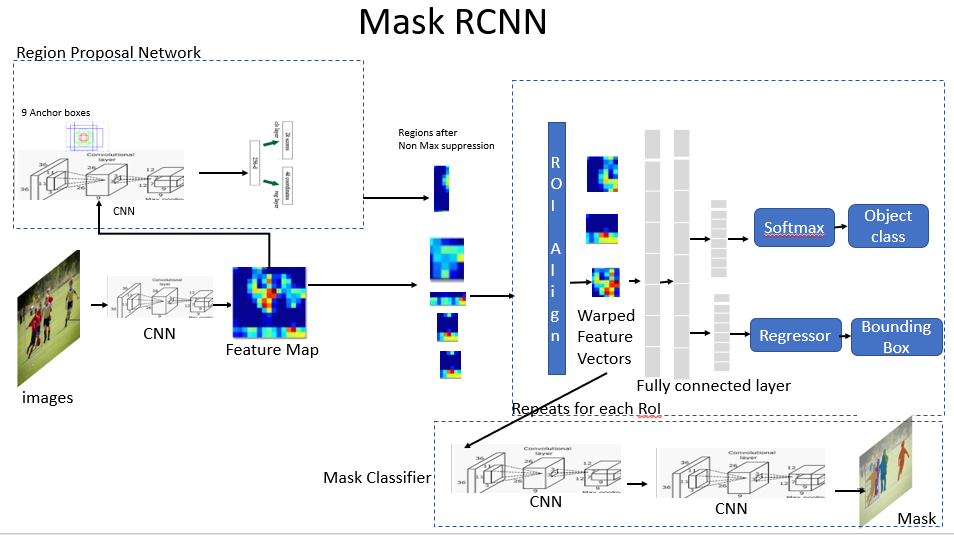

1. 800~1024 크기의 image를 resize해준다. (Bilinear Interpolation 사용)  

2. BackBone Network의 input에 맞추어 주기 위해서 1024x1024의 크기로 padding을 이용해서 맞춤  

3. BackBone Network를 이용해서 각 layer에서 feature map을 얻는다.  

4. BackBone Network를 통해 얻은 feature map를 기반으로 새로운 feature map을 **FPN**을 이용해서 얻는다.  

5. 최종 생성된 feature map를 기반으로 **RPN**을 적용하여 classification, bbox regression output을 불러온다.  

6. 출력으로 얻은 bbox regression output값을 원해 이미지로 바꾸어 anchor box를 생성한다.  

7. Non-Max-Supression을 이용하여 생성된 anchor box중에서 score이 가장 높은 anchor box를 제외하고 모두 삭제  

8. 크기가 제각각인 anchor box를 기존의 Faster R-CNN이 사용하던 RoI Pooling이 아닌 **RoI Allign**기법을 사용  

9. Classification, bbox regression branch, mask branch, 총 3개의 module에 anchor box의 값을 적용




#### 1. Bounding Box의 사용
#### 2. Segmentation Mask의 사용 (RoI마다)
  - RoI마다 작은 FCN(fully concolution network)을 연결하여 classification과 bounding box regression에 사용이 될 수 있도록 해 줌
  - mask branch를 추가하는 것은 계산량에 큰 증가를 가져오지 않기 때문에 네트워크의 사용 무게에 변화가 별로 없다는 장점이 존재한다. 

#### RPN (Region Proposal Network)
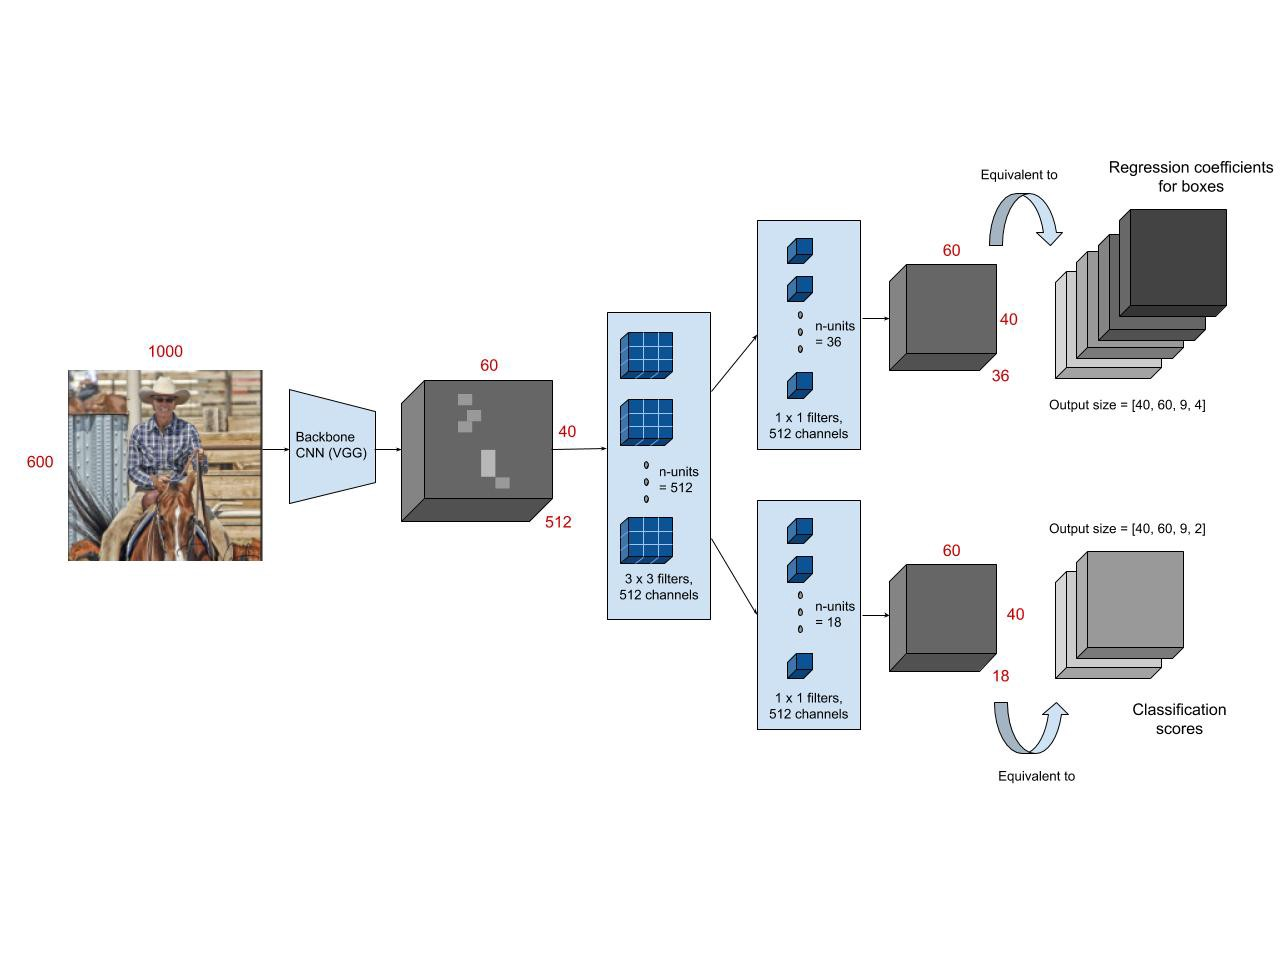

### FPN (Feature Pyramid Network)
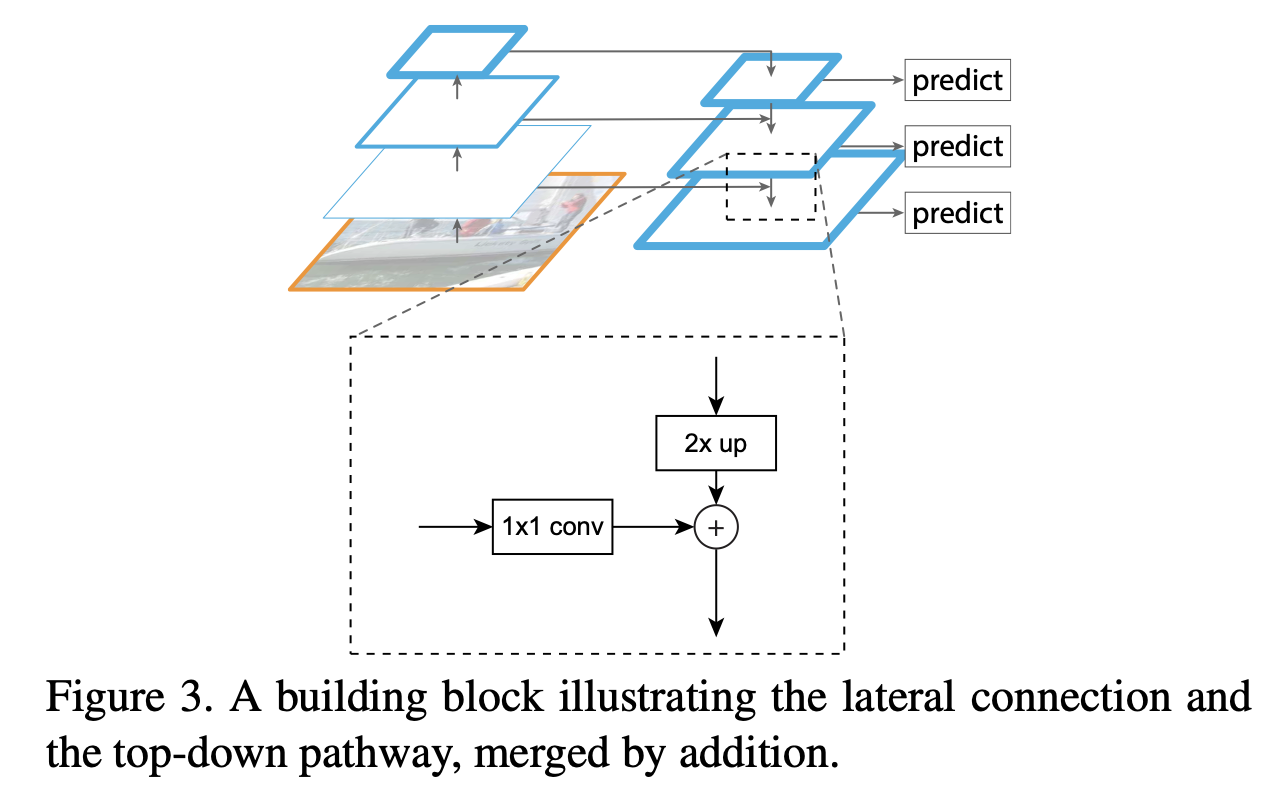

In [ ]:
class RPNHead(nn.Module):
    """
    Adds a simple RPN Head with classification and regression heads
    Args:
        in_channels (int): number of channels of the input feature
        num_anchors (int): number of anchors to be predicted
    """

    def __init__(self, in_channels, num_anchors):
        super(RPNHead, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, in_channels, kernel_size=3, stride=1, padding=1
        )
        self.cls_logits = nn.Conv2d(in_channels, num_anchors, kernel_size=1, stride=1)
        self.bbox_pred = nn.Conv2d(
            in_channels, num_anchors * 4, kernel_size=1, stride=1
        )

        for layer in self.children():
            torch.nn.init.normal_(layer.weight, std=0.01)
            torch.nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        # type: (List[Tensor]) -> Tuple[List[Tensor], List[Tensor]]
        logits = []
        bbox_reg = []
        for feature in x:
            t = F.relu(self.conv(feature))
            logits.append(self.cls_logits(t))
            bbox_reg.append(self.bbox_pred(t))
        return logits, bbox_reg

1. 기존의 Faster R-CNN의 경우에는 backbone의 결과로 나온 1개의 feature map에서 RoI를 생성하고 classification가 bbox regression을 진행한다. 그렇게 하면 feature map이 backbone model에서 최종 layer의 output이 되는데 이렇게 layer을 계속 통과하다 보면 중요한 feature만 남고 정작 중간중간에 있는 feature들은 손실되는 단점이 존재한다.  

2. 또한, 최종 layer에서 다양한 크기의 object를 검출해야 하기 떄문에 여러 scale의 anchor이 필요하다는 점도 단점으로 작용한다.  

3. 그래서 Feature Pyramid Network를 적용하게 된 것이다.  

4. 마지막 feature layer에서 점점 이전 feature map들을 더해 나가면서 이전 정보까지 유지할 수 있도록 해 준다.  

5. 이렇게 하면 여러 scale로 anchor을 생성할 필요가 없게 되며, 모두 동일한 scale의 anchor을 생성할 수 있다.  

6. 따라서 작은 feature map에서는 큰 anchor을 생성하여 큰 object를, 큰 feature map에서는 작은 anchor을 생성하여 작은 object를 detect할 수 있도록 한다.  

7. 마자막 layer에서는 upsampling을 이용해서 feature map들을 더해 나가며, 2배로 upsampling을 진행한 뒤에 1x1 Fully Convolution연산을 통해서 filter의 개수를 맞추어 준 뒤에 더해서 새로운 filter map을 출력한다.

### Mask R-CNN
1. Pytorch Torch Vision Model의 항목중에서 detection에서 찾을 수 있는 model이다.
2. 개인적으로 이 코드를 보면서 모델의 구조를 좀 더 잘 이해할 수 있었는데, Faster R-CNN의 구조를 기반으로 하되 **RCN구조를 이용해서 예측을 하기에 앞서서 FPN**구조를 추가 했음을 알 수 있다. 
  - 먼저 RCN으로 이미지에 대한 feature map을 출력한 후에 이를 바탕으로 FPN이 다시 feature map을 출력한다.
  - 최종 feature map에 anchor을 k개의 class만큼, 즉 anchor의 크기가 MxM이었으면 픽셀별로 연산을 수행하기 떄문에 MxMxK개의 예측을 한다.
  - 결국 bounding box를 출력해 주는 것이 목적이기 때문에 P(i), 즉i번째 클래스에 대한 예측값이 올바르면 1을, 틀리면 0을 부여함으로서 가중치에 변화를 주어 올바른 bounding box를 도출해 낼 수 있도록 하는 모델이다.
  

In [ ]:
from collections import OrderedDict

from torch import nn

from torchvision.ops import MultiScaleRoIAlign

from ._utils import overwrite_eps
from ..utils import load_state_dict_from_url

from .faster_rcnn import FasterRCNN
from .backbone_utils import resnet_fpn_backbone, _validate_trainable_layers

__all__ = [
    "MaskRCNN", "maskrcnn_resnet50_fpn",
]


class MaskRCNN(FasterRCNN):
    def __init__(self, backbone, num_classes=None,
                 # transform parameters
                 min_size=800, max_size=1333,
                 image_mean=None, image_std=None,
                 # RPN parameters
                 rpn_anchor_generator=None, rpn_head=None,
                 rpn_pre_nms_top_n_train=2000, rpn_pre_nms_top_n_test=1000,
                 rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=1000,
                 rpn_nms_thresh=0.7,
                 rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                 rpn_score_thresh=0.0,
                 # Box parameters
                 box_roi_pool=None, box_head=None, box_predictor=None,
                 box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=100,
                 box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                 box_batch_size_per_image=512, box_positive_fraction=0.25,
                 bbox_reg_weights=None,
                 # Mask parameters
                 mask_roi_pool=None, mask_head=None, mask_predictor=None):

        assert isinstance(mask_roi_pool, (MultiScaleRoIAlign, type(None)))

        if num_classes is not None:
            if mask_predictor is not None:
                raise ValueError("num_classes should be None when mask_predictor is specified")

        out_channels = backbone.out_channels

        if mask_roi_pool is None:
            mask_roi_pool = MultiScaleRoIAlign(
                featmap_names=['0', '1', '2', '3'],
                output_size=14,
                sampling_ratio=2)

        if mask_head is None:
            mask_layers = (256, 256, 256, 256)
            mask_dilation = 1
            mask_head = MaskRCNNHeads(out_channels, mask_layers, mask_dilation)

        if mask_predictor is None:
            mask_predictor_in_channels = 256  # == mask_layers[-1]
            mask_dim_reduced = 256
            mask_predictor = MaskRCNNPredictor(mask_predictor_in_channels,
                                               mask_dim_reduced, num_classes)

        super(MaskRCNN, self).__init__(
            backbone, num_classes,
            # transform parameters
            min_size, max_size,
            image_mean, image_std,
            # RPN-specific parameters
            rpn_anchor_generator, rpn_head,
            rpn_pre_nms_top_n_train, rpn_pre_nms_top_n_test,
            rpn_post_nms_top_n_train, rpn_post_nms_top_n_test,
            rpn_nms_thresh,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            rpn_score_thresh,
            # Box parameters
            box_roi_pool, box_head, box_predictor,
            box_score_thresh, box_nms_thresh, box_detections_per_img,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights)

        self.roi_heads.mask_roi_pool = mask_roi_pool
        self.roi_heads.mask_head = mask_head
        self.roi_heads.mask_predictor = mask_predictor


class MaskRCNNHeads(nn.Sequential):
    def __init__(self, in_channels, layers, dilation):
        d = OrderedDict()
        next_feature = in_channels
        for layer_idx, layer_features in enumerate(layers, 1):
            d["mask_fcn{}".format(layer_idx)] = nn.Conv2d(
                next_feature, layer_features, kernel_size=3,
                stride=1, padding=dilation, dilation=dilation)
            d["relu{}".format(layer_idx)] = nn.ReLU(inplace=True)
            next_feature = layer_features

        super(MaskRCNNHeads, self).__init__(d)
        for name, param in self.named_parameters():
            if "weight" in name:
                nn.init.kaiming_normal_(param, mode="fan_out", nonlinearity="relu")
            # elif "bias" in name:
            #     nn.init.constant_(param, 0)


class MaskRCNNPredictor(nn.Sequential):
    def __init__(self, in_channels, dim_reduced, num_classes):
        super(MaskRCNNPredictor, self).__init__(OrderedDict([
            ("conv5_mask", nn.ConvTranspose2d(in_channels, dim_reduced, 2, 2, 0)),
            ("relu", nn.ReLU(inplace=True)),
            ("mask_fcn_logits", nn.Conv2d(dim_reduced, num_classes, 1, 1, 0)),
        ]))

        for name, param in self.named_parameters():
            if "weight" in name:
                nn.init.kaiming_normal_(param, mode="fan_out", nonlinearity="relu")
            # elif "bias" in name:
            #     nn.init.constant_(param, 0)


model_urls = {
    'maskrcnn_resnet50_fpn_coco':
        'https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth',
}


def maskrcnn_resnet50_fpn(pretrained=False, progress=True,
                          num_classes=91, pretrained_backbone=True, trainable_backbone_layers=None, **kwargs):
    trainable_backbone_layers = _validate_trainable_layers(
        pretrained or pretrained_backbone, trainable_backbone_layers, 5, 3)

    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False
    backbone = resnet_fpn_backbone('resnet50', pretrained_backbone, trainable_layers=trainable_backbone_layers)
    model = MaskRCNN(backbone, num_classes, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['maskrcnn_resnet50_fpn_coco'],
                                              progress=progress)
        model.load_state_dict(state_dict)
        overwrite_eps(model, 0.0)
    return model

In [ ]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.anchor_utils import AnchorGenerator

# 다양한 크기의 segmentation을 진행해 주어야 하는 객체들이 있을 수 있기 떄문에
# 5개의 서로 다른 size와 3개의 서로 다른 aspect_ratio를 지정해 준다.
anchor_generator = AnchorGenerator(sizes = ((32, 64, 128, 256, 512),),
                            aspect_ratios = ((0.5, 1.0, 2.0),))

# 사전 훈련된 모델의 feature map 데이터를 입력값으로 주어지도록 한다.
backbone = torchvision.models.mobilenet_v2(pretrained = True).features
# mobilenet_v2의 경우에는 1280개의 out_channel을 갖는다.
# out_channel의 개수를 정해주지 않고 실행 해 주니 AttributeError이 떴다.
# 단, Mask R-CNN의 경우에는 반드시 backbone의 output channel값을 알려 주어야 한다.

backbone.out_channels = 1280

# backbone network가 feature map을 return 하면 featmap이름을 ['0']으로 지정해서
# RoI, 즉 정해진 영역에 pooling등의 과정을 적용한다.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names = ['0'],
                                                output_size = 7,
                                                sampling_ratio = 2)

mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names = ['0'],
                                                    output_size = 14,
                                                    sampling_ratio = 2)                            

model = MaskRCNN(backbone = backbone,
                num_classes = 2,
                box_roi_pool = roi_pooler,
                mask_roi_pool = mask_roi_pooler,
                rpn_anchor_generator = anchor_generator)
model.eval()

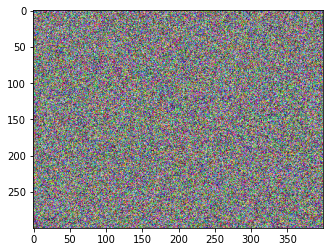

In [17]:
import cv2
import matplotlib.pyplot as plt

plt.imshow(sample_input[0].reshape(300, 400, 3))

In [ ]:
sample_input = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predict = model(sample_input)
print(predict)

In [ ]:
import torch, torchvision
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained = True)
model.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in